In [46]:
### Define our Connector

import requests,os,time
def ratelimit(dt):
    "A function that handles the rate of your calls."
    time.sleep(dt) # sleep one second.

class Connector():
  def __init__(self,logfile,overwrite_log=False,connector_type='requests',session=False,path2selenium='',n_tries = 5,timeout=30,waiting_time=0.5):
    """This Class implements a method for reliable connection to the internet and monitoring. 
    It handles simple errors due to connection problems, and logs a range of information for basic quality assessments
    
    Keyword arguments:
    logfile -- path to the logfile
    overwrite_log -- bool, defining if logfile should be cleared (rarely the case). 
    connector_type -- use the 'requests' module or the 'selenium'. Will have different since the selenium webdriver does not have a similar response object when using the get method, and monitoring the behavior cannot be automated in the same way.
    session -- requests.session object. For defining custom headers and proxies.
    path2selenium -- str, sets the path to the geckodriver needed when using selenium.
    n_tries -- int, defines the number of retries the *get* method will try to avoid random connection errors.
    timeout -- int, seconds the get request will wait for the server to respond, again to avoid connection errors.
    """
    
    ## Initialization function defining parameters. 
    self.n_tries = n_tries # For avoiding triviel error e.g. connection errors, this defines how many times it will retry.
    self.timeout = timeout # Defining the maximum time to wait for a server to response.
    self.waiting_time = waiting_time # define simple rate_limit parameter.
    ## not implemented here, if you use selenium.
    if connector_type=='selenium':
      assert path2selenium!='', "You need to specify the path to you geckodriver if you want to use Selenium"
      from selenium import webdriver 
      ## HIN download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases

      assert os.path.isfile(path2selenium),'You need to insert a valid path2selenium the path to your geckodriver. You can download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases'
      self.browser = webdriver.Firefox(executable_path=path2selenium) # start the browser with a path to the geckodriver.

    self.connector_type = connector_type # set the connector_type
    
    if session: # set the custom session
      self.session = session
    else:
      self.session = requests.session()
    self.logfilename = logfile # set the logfile path
    ## define header for the logfile
    header = ['id','project','connector_type','t', 'delta_t', 'url', 'redirect_url','response_size', 'response_code','success','error']
    if os.path.isfile(logfile):        
      if overwrite_log==True:
        self.log = open(logfile,'w')
        self.log.write(';'.join(header))
      else:
        self.log = open(logfile,'a')
    else:
      self.log = open(logfile,'w')
      self.log.write(';'.join(header))
    ## load log 
    with open(logfile,'r') as f: # open file
        
      l = f.read().split('\n') # read and split file by newlines.
      ## set id
      if len(l)<=1:
        self.id = 0
      else:
        self.id = int(l[-1][0])+1
            
  def get(self,url,project_name):
    """Method for connector reliably to the internet, with multiple tries and simple error handling, as well as default logging function.
    Input url and the project name for the log (i.e. is it part of mapping the domain, or is it the part of the final stage in the data collection).
    
    Keyword arguments:
    url -- str, url
    project_name -- str, Name used for analyzing the log. Use case could be the 'Mapping of domain','Meta_data_collection','main data collection'. 
    """
     
    project_name = project_name.replace(';','-') # make sure the default csv seperator is not in the project_name.
    if self.connector_type=='requests': # Determine connector method.
      for _ in range(self.n_tries): # for loop defining number of retries with the requests method.
        ratelimit(self.waiting_time)
        t = time.time()
        try: # error handling 
          response = self.session.get(url,timeout = self.timeout) # make get call

          err = '' # define python error variable as empty assumming success.
          success = True # define success variable
          redirect_url = response.url # log current url, after potential redirects 
          dt = t - time.time() # define delta-time waiting for the server and downloading content.
          size = len(response.text) # define variable for size of html content of the response.
          response_code = response.status_code # log status code.
          ## log...
          call_id = self.id # get current unique identifier for the call
          self.id+=1 # increment call id
          #['id','project_name','connector_type','t', 'delta_t', 'url', 'redirect_url','response_size', 'response_code','success','error']
          row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row to be written in the log.
          self.log.write('\n'+';'.join(map(str,row))) # write log.
          self.log.flush()
          return response,call_id # return response and unique identifier.

        except Exception as e: # define error condition
          err = str(e) # python error
          response_code = '' # blank response code 
          success = False # call success = False
          size = 0 # content is empty.
          redirect_url = '' # redirect url empty 
          dt = t - time.time() # define delta t

          ## log...
          call_id = self.id # define unique identifier
          self.id+=1 # increment call_id

          row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row
          self.log.write('\n'+';'.join(map(str,row))) # write row to log.
          self.log.flush()
    else:
      t = time.time()
      ratelimit(self.waiting_time)
      self.browser.get(url) # use selenium get method
      ## log
      call_id = self.id # define unique identifier for the call. 
      self.id+=1 # increment the call_id
      err = '' # blank error message
      success = '' # success blank
      redirect_url = self.browser.current_url # redirect url.
      dt = t - time.time() # get time for get method ... NOTE: not necessarily the complete load time.
      size = len(self.browser.page_source) # get size of content ... NOTE: not necessarily correct, since selenium works in the background, and could still be loading.
      response_code = '' # empty response code.
      row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row 
      self.log.write('\n'+';'.join(map(str,row))) # write row to log file.
      self.log.flush()
    # Using selenium it will not return a response object, instead you should call the browser object of the connector.
    ## connector.browser.page_source will give you the html.
      return None,call_id

# Session 10
## Scraping 2 - Parsing
*Snorre Ralund*

Yesterday I gave you some powerful tricks. Tricks that will work when the data is already shipped in a neat format. However this is not the rule. Today we shall learn the art of parsing unstructured text and a more principled and advanced method of parsing HTML.

This will help you build ***custom datasets*** within just a few hours or days work, that would have taken ***months*** to curate and clean manually.

## Agenda
### Storing
- for **replicability** and **data quality** 
- reading and writing of files.


**Parsing and cleaning raw data** 

HTML
* Understanding the basics of HTML syntax.
* Traversing and Navigating HTML trees using BeautifulSoup. Examples include: 
    * Extracting Text from HTML, 
    * Extracting Tables, 
    * Parsing of "unknown" structures.
_________________________
Raw Text
* Learning the of Regular Expressions for extracting patterns in strings. 
    * Very valuable when cleaning and validating data, and for information extraction from raw text.

_________________________


# Sidestep(1): APIS
- Do not look for the backdoor if there is a front.
    - Use the API if provided.


- Create a developer account. 
- Learn how to Authenticate.
    - Read the docs. 
- Construct your queries

**Examples**
- Twitter, YouTube, Reddit, Facebook, Github, Stackexchange and many more...
- Google Translate, Transcribe and ML APIS


# Sidestep(2): Interactions and Automated Browsing
Sometimes scraping tasks demand interactions (e.g. login, scrolling, clicking), and a no XHR data can be found easily, so you need the browser to execute the scripts before you can get the data.

Here we use the `Selenium` package in combination with the `geckodriver` - download the latest release [here](download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases). It allows you to animate a browser. I won't go into detail here, but just wanted to mention it. 

Installation (and maintainance of compatability) can be a little tough, but instead of trawling through crazy stackoverflow threads about your Issue, my experience tells me that downloaded the latest release, and installing the latest selenium version is always the cure.

In [ ]:

from selenium import webdriver
## download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases
path2gecko = 'geckodriver' # define path to your geckodriver
browser = webdriver.Firefox(executable_path=path2gecko) # start the browser with a path to the geckodriver.
browser.get('https://www.google.com') # opens a webpage using the browser objects get method.

## The HTML Tree
HTML has a Tree structure. 

Each node in the tree has:
        - Children, siblings, parents - descendants. 
        - Ids and attributes

<img src="http://www.openbookproject.net/tutorials/getdown/css/images/lesson4/HTMLDOMTree.png"/>


## Important syntax and patterns
_______________
```html 
<p>The p tag indicates a paragraph <p/>
```
_______________
```html 
<b>The b tag makes the text bold, giving us a clue to its importance </b>
```
output: <b>The b tag makes the text bold, giving us a clue to its importance </b>
```html 
The <strong>tag</strong> makes the text bold, giving us a clue to its importance
```

output: The <strong>tag</strong> makes the text bold, giving us a clue to its importance

```html 
<em>The em tag emphasize the text</em>, giving us a clue to its importance
```

output: <em>The em tag makes emphasize the text</em>, giving us a clue to its importance

___________
```html 
<h1>h1</h1><h2>h2</h2><h2>h3</h3><b>Headers give similar clues</b>
```
output:
<h1>h1</h1><h2>h2</h2><h3>h3</h3><b>Headers give similar clues</b>
_________________
```html 
<a href="www.google.com">The a tag creates a hyperlink <a/>
```
output: <a href="www.google.com">The a tag creates a hyperlink <a/>
_____________
Finally you have the terrible and confusing iframe: 
```html
 <iframe src="https://www.google.com"></iframe>
```
_________________

## How do we find our way around this tree?
* extracting string patterns using .split and regular expresssions as we did yesterday.
* Specifying paths using css-selectors,xpath syntax. 
* A more powerful and principled (+readable) way is to use the ```python``` module ```BeautifulSoup``` to parse and traverse the tree.

### Selectors 
Define a unique path to an element in the HTML tree.
- quick but has to be hardcoded and also more likely to break.


In [4]:
# selenium example
browser.get('https://www.facebook.com')
# find login button.

# define username

# define password

# click on the submit button

## Parsing HTML with BeautifulSoup
BeautifulSoup makes the html tree navigable. 
It allows you to:
    * Search for elements by tag name and/or by attribute.
    * Iterate through them, go up, sideways or down the tree.
    * Furthermore it helps you with standard tasks such as extracting raw text from html,
    which would be a very tedious task if you had to hardcode it using `.split` commands and using your own regular expressions will be unstable.

In [4]:
# scraping newspaper articles example.
connector = Connector('log_sds_lecture10.csv')
url = 'https://www.theguardian.com/us-news/2019/aug/14/taco-eating-contest-death-fresno-california'
response,call_id = connector.get(url,'test_call')
html = response.text

In [6]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(html,'lxml') # parse the raw html using BeautifoulSoup

In [7]:
# extract hyperlinks
links = soup.find_all('a') # find all a tags -connoting a hyperlink.
[link['href'] for link in links if link.has_attr('href')][0:5] # unpack the hyperlink from the a nodes.

['#maincontent',
 'https://www.theguardian.com/international',
 'https://support.theguardian.com/contribute?INTCMP=header_support_contribute&acquisitionData=%7B%22source%22:%22GUARDIAN_WEB%22,%22componentType%22:%22ACQUISITIONS_HEADER%22,%22componentId%22:%22header_support_contribute%22%7D',
 'https://support.theguardian.com/subscribe?INTCMP=header_support_subscribe&acquisitionData=%7B%22source%22:%22GUARDIAN_WEB%22,%22componentType%22:%22ACQUISITIONS_HEADER%22,%22componentId%22:%22header_support_subscribe%22%7D',
 'https://support.theguardian.com/contribute?INTCMP=header_support_contribute&acquisitionData=%7B%22source%22:%22GUARDIAN_WEB%22,%22componentType%22:%22ACQUISITIONS_HEADER%22,%22componentId%22:%22header_support_contribute%22%7D']

In [8]:
headline = soup.find('h1') # search for the first headline: h1 tag. 
name = headline['class'][0].strip() # use the class attribute name as column name.
value = headline.text.strip() # extract text using build in method.
print(name,':',value)

content__headline : Man dies after taco-eating contest in California


In [9]:
article_text = soup.find('div',{'class':'content__article-body from-content-api js-article__body'}).text # find the content.

Say we are interested in how articles cite sources to back up their story i.e. their hyperlink behaviour within the article, and we want to see if the media has changed their behaviour.

We know how to search for links. But the cool part is that we can search from anywhere in the HTML tree. This means that once we have located the article content node - as above - we can search from there. This results in hyperlinks used within the article text.


In [321]:
# find the article_content node
article_content = soup.find('div',{'class':'content__article-body from-content-api js-article__body'})
# find citations within the article content.
citations = article_content.find_all('a')

In [325]:
citation_links = [] # define container to the hyperlinks
for citation in citations: # iterate through each citation node
    if citation.has_attr('data-link-name'): # check if it has the right attribute
        if citation['data-link-name'] =='in body link': # and if the value of that attribute is correct
            #print(citation['href'])
            citation_links.append(citation['href']) #  add link to the container

## Scraping without hardcoding every element to collect.  
### Hands-on example: Continuing the Cryptomarket scrape. 
When scraping a large and diverse website or even crawling many different, it can be useful to design more generic parsing schemes, were you haven't seen all elements you want to keep before hand. In the following example I demonstrate a simple example of this.

Imagine we wanted data on the Cryptomarkets:
* Go to the front page of a [Cryptomarket page](https://coinmarketcap.com). Looking in the **>Network Monitor<** we find a XHR file (helping their search function) containing links to Cryptocoin. Now we have the link to each page we want to visit. 

Visit this example: http://coinmarketcap.com/currencies/ethereum/

Yesterday we saw how to find the XHR file with the underlying data behind the Chart. Now we want all the metadata displayed. 

Using the inspector we find that the information we want is located by a node tagged with `ul` - *"unordered list"* tag - with the defining class attribute *'list-unstyled details-panel-item--links'*. And the information is located in the `li` tag *"list item"*.

First we locate this node using the `find` method. 


In [216]:
url = 'https://coinmarketcap.com/currencies/ethereum/' # define the example url
response = connector.get(url,'crypto_mapping') # 
soup = BeautifulSoup(response.text,'lxml') # parse the HTML

In [221]:
list_node = soup.find('ul',{'class':'list-unstyled details-panel-item--links'}) # search for the ul node

Now starting from this list_node, we can search for each list item - li node, using the find_all method.

In [326]:
list_items = list_node.find_all('li') # search for all list elements children of the list_node 

From this we extract the information. Without having to hardcode all extractions we exploit that each html node has a attribute ('title'). We can therefore just loop through each node, extracting the title attribute and the text. ***-- This furthermore allows us to scrape content we did not know was there.***

We use the title as the key in the dictionary. The value we are interested in two things, either the *hyperlink*, or the the *text* on display.

In [249]:
d = {} # defining our container
for list_item in list_items:
    key = list_item.span['title'] # attributes of a node can be fetched with dictionary-like syntax.
    if list_item.a!=None: # check if the node has a hyperlink.
        value = list_item.a['href'] # list_item.a ==list_item.find('a') returns the first node found.
    else:
        value = list_item.text.strip()
    d[key] = value
d

{'Announcement': 'https://bitcointalk.org/index.php?topic=428589.0',
 'Chat': 'https://gitter.im/orgs/ethereum/rooms',
 'Explorer': 'https://etherchain.org/',
 'Message Board': 'https://forum.ethereum.org/',
 'Rank': 'Rank 2',
 'Source Code': 'https://github.com/ethereum',
 'Tags': 'Coin\nMineable',
 'Website': 'https://www.ethereum.org/'}

In [280]:


d['Source Code'],d['Source Code'].split('/')[-1]


'ethereum'

## Storage
** For quality** 
- interactive process of improvements.
- quality assessment based on the log is easier with the raw html responses stored.

**For replicability**
- documentation and transparancy

In [53]:
# start by defining a Project name
project = 'erc_funding'
import os # generel package for interacting with the system
### among other things automate folder creation
import os
## create folder
if not os.path.isdir(project):    # check if folder exist
    os.mkdir(project)

subfolders = ['/mapping','/raw_data','/parsed_data']

for directory in subfolders: 
    if not os.path.isdir(directory):
        os.mkdir(project+directory) # create subfolders


## Reading and Writing

### Text Encoding - from 0's and 1's to signs and letters.

- utf-8 
    - Most widely used standard that also handles emojiis 
- but others are also used so we need to be aware.

In [55]:
# use the codecs module instead of open
##f = open('testfile','w')
import codecs
f = codecs.open('testfile','w','utf-8') # open command with a specified encoding.
f.write('😋 😎 😍 ')

### if encoding error happens anyways use the `ftfy`-package

In [43]:
with open('encodingerror','w') as f:
    f.write('æøåáé'.encode('utf-8').decode('latin1'))

In [45]:
import ftfy
with open('encodingerror','r') as f:
    
    s = f.read()
    print(s) # print the encoding error
    print(ftfy.fix_text(s)) ## ftfy fixes the encoding error

Ã¦Ã¸Ã¥Ã¡Ã©
æøåáé


## Storage formats
- json
     - Works as a dictionary (almost). Good for adding metadata to each data point
- multiple stacked json files.
    - json strings seperated by e.g. '\n\r'. 
    - Good for large projects

## Reading and Writing files from a folder

### ERC example
Imagine we wanted to analyze whether the European funding behaviour was biased towards certain countries and gender. We might decide to scrape who has received funding from the ERC.
https://erc.europa.eu/

* First we figure find navigate the grant listings.
* Next we figure out how to page these results. 
* And finally we want to grab the information.


In [196]:
from tqdm import tqdm_notebook as tqdm # Module for tracking progress. conda install -c conda-forge tqdm
connector = Connector('erc_log.csv',overwrite_log=True)

base_url = 'https://erc.europa.eu/projects-figures/erc-funded-projects/results?items_per_page=100&search_api_views_fulltext=&'
n_pages = 10004//100+1
for i in tqdm(range(0,n_pages)):
    # define the url
    url = base_url+'page=%d'%i
    # download the url
    response,call_id = connector.get(url,'erc_mapping')
        
    ## dump the raw html response
    file_path = project+'/mapping'+'/%d'%call_id
    with codecs.open(file_path,'w','utf-8') as f:
        f.write(response.text)

## Parsing the results

In [197]:
## First we list the files
import os
path = project+'/mapping/'
files = [path+filename for filename in os.listdir(path)]
print(len(files))

101


In [198]:
## Start with a random page and create a parsing scheme
import random 
filename = random.choice(files)
filename

'erc_funding/mapping/25'

In [61]:
## read the file
with codecs.open(filename,'r','utf-8') as f:
    html = f.read()

In [73]:
## load the raw html into a Beautifulsoup object
from bs4 import BeautifulSoup
import bs4

In [199]:
import pandas as pd
def parse_erc(filename):
    # read the file
    with codecs.open(filename,'r','utf-8') as f:
        html = f.read()
    # turn raw string into a navigable html tree.
    soup = BeautifulSoup(html,'lxml')
    # find result list.
    result_list = soup.find('div',{'class':'view-content'}) # find elements using tag name and class attribute
    # loop through the "children" nodes of the result list node.
    data = [] # define container for the parsed datapoints
    for child in result_list.children:
        if type(child)==bs4.NavigableString: #check if it is a string or a html node. 
            continue # If it is a string the next part of the loop will be skipped.
            
        # the "child" is now the node containing the ERC research project information.
        ## structured as a pseudo table with rows containing a title and a value. 
        # define datapoint container
        d = {}
        # iterate through the content of the "pseudo" table.
        for grand_child in child.children:
            if type(grand_child)==bs4.NavigableString:
                continue # same procedure
            # use the span tag as separator between the column name and the value.
            spans = grand_child.findAll('span')
            # setup two different conditions.
            if len(spans)==2:
                key,value = spans
            else: # special case.
                key,value = [i for i in list(grand_child.find('span').children) if not type(i)==bs4.NavigableString]
            # add the datapoint to the it to the data container `d`
            d[key.text] = value.text # get the text of the two nodes using the object specific method .text        
            # Using the strong tag to find Founding amount in the raw summary text.
            ### The strong tag is a general heuristic.
            strong = grand_child.findAll('strong') # using the findAll method to locate the text marked with the 'strong' tag 
            if len(strong)>0: # check if node contains the strong tag.
                for node in strong: # if so iterate through it.
                    key = node.text # get the text
                    value = str(node.next.next) # get the value using the heuristic that 
    #                print(key,node.next,value)
                    d[key] = value
        # clean values for whitespace
        d = {key:value.strip() for key,value in d.items()}
        # add meta data for merging with the log
        d['filename'] = filename
        data.append(d) # append it to the data container.
    # convert to dataframe
    df = pd.DataFrame(data)
    return df



In [200]:
# run it on all pages
# import tqdm for monitoring the progress.
from tqdm import tqdm_notebook as tqdm
dfs = []
for filename in tqdm(files):
    dfs.append(parse_erc(filename))
df = pd.concat(dfs)

## Reliability and Data quality (1)
** For the Exam**: Dedicate a Notebook to the analysis of data quality

### Inspect the data
- Does the number of data point match our expectation?
- Counting Nan values and empty strings
- Do Random Inspections

In [185]:
## RANDOM INSPECTION
df.sample(10)

,Summary,Call Details,Duration,Host Institution (HI),Max ERC Funding,Project,Project acronym,Researcher (PI),Summary,filename
47,Wave-particle interactions are ubiquitous in n...,"Starting Grant (StG), PE2, ERC-2018-STG","Start date: 2019-05-01, End date: 2024-04-30",UNIVERSIDAD DE SEVILLA,1 512 250 €,Taming the particle transport in magnetized pl...,3D-FIREFLUC,Eleonora VIEZZER,Wave-particle interactions are ubiquitous in n...,erc_funding/mapping/56
37,Topological insulators constitute a novel clas...,"Advanced Grant (AdG), PE3, ERC-2010-AdG_20100224","Start date: 2011-04-01, End date: 2016-03-31",JULIUS-MAXIMILIANS-UNIVERSITAT WURZBURG,2 419 590 €,Exploring the physics of 3-dimensional topolog...,3-TOP,Laurens Wigbolt Molenkamp,Topological insulators constitute a novel clas...,erc_funding/mapping/31
86,This project investigates the two-way relation...,"Starting Grant (StG), LS2, ERC-2017-STG","Start date: 2018-04-01, End date: 2023-03-31",CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE CNRS,1 499 750 €,Spatio-temporal Organization and Expression of...,4D-GenEx,Antoine COULON,This project investigates the two-way relation...,erc_funding/mapping/72
63,"At the end of their life, stars spread their i...","Starting Grant (StG), PE9, ERC-2013-StG","Start date: 2013-09-01, End date: 2018-08-31",CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE CNRS,1 166 231 €,3D Interstellar Chemo-physical Evolution,3DICE,Valentine Wakelam,"At the end of their life, stars spread their i...",erc_funding/mapping/27
63,"At the end of their life, stars spread their i...","Starting Grant (StG), PE9, ERC-2013-StG","Start date: 2013-09-01, End date: 2018-08-31",CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE CNRS,1 166 231 €,3D Interstellar Chemo-physical Evolution,3DICE,Valentine Wakelam,"At the end of their life, stars spread their i...",erc_funding/mapping/8
57,Antigenic variation is a widely employed strat...,"Starting Grant (StG), LS6, ERC-2016-STG","Start date: 2017-04-01, End date: 2022-03-31",LUDWIG-MAXIMILIANS-UNIVERSITAET MUENCHEN,1 498 175 €,The role of three-dimensional genome architect...,3D_Tryps,Tim Nicolai SIEGEL,Antigenic variation is a widely employed strat...,erc_funding/mapping/38
94,It was early predicted by M. Green and coeval ...,"Starting Grant (StG), PE7, ERC-2017-STG","Start date: 2018-02-01, End date: 2023-01-31",UNIVERSIDAD AUTONOMA DE MADRID,1 499 719 €,4-Colours/2-Junctions of III-V semiconductors ...,4SUNS,María Nair LOPEZ MARTINEZ,It was early predicted by M. Green and coeval ...,erc_funding/mapping/74
2,The overall goal of 14Constraint is to enhance...,"Advanced Grant (AdG), PE10, ERC-2015-AdG","Start date: 2016-12-01, End date: 2021-11-30",MAX-PLANCK-GESELLSCHAFT ZUR FORDERUNG DER WISS...,2 283 747 €,Radiocarbon constraints for models of C cyclin...,14Constraint,Susan Trumbore,The overall goal of 14Constraint is to enhance...,erc_funding/mapping/2
75,Understanding the many-body physics of strongl...,"Starting Grant (StG), PE2, ERC-2011-StG_20101014","Start date: 2011-08-01, End date: 2016-07-31",RUPRECHT-KARLS-UNIVERSITAET HEIDELBERG,1 469 040 €,Three-Component Fermi Gas Lattice Experiment,3FLEX,Selim Jochim,Understanding the many-body physics of strongl...,erc_funding/mapping/39
83,"Electronic doping, the control over the charge...","Proof of Concept (PoC), ERC-2018-PoC","Start date: 2019-06-01, End date: 2020-11-30",TECHNISCHE UNIVERSITEIT DELFT,150 000 €,Designing Devices by Doping on Demand,4D,Arjan HOUTEPEN,"Electronic doping, the control over the charge...",erc_funding/mapping/99


In [215]:
## ERC lists 10004
len(df), len(df.drop_duplicates())

(10004, 10004)

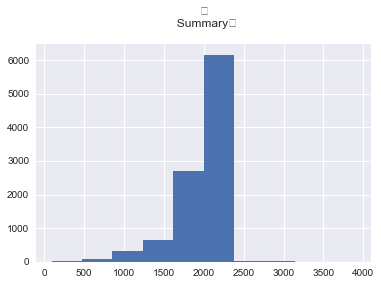

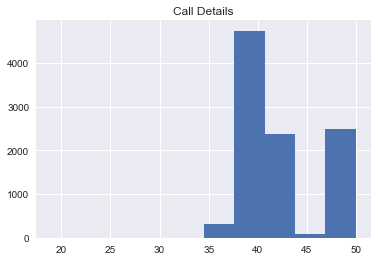

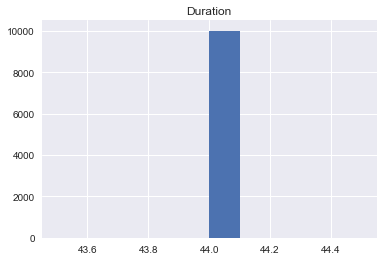

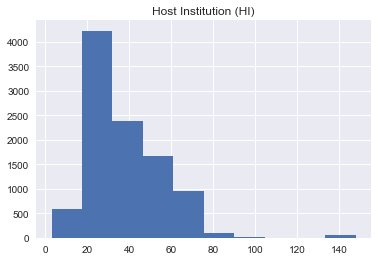

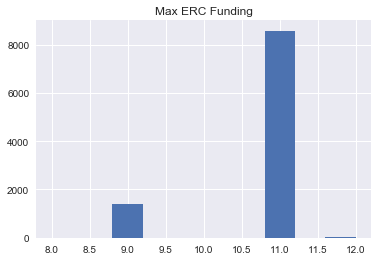

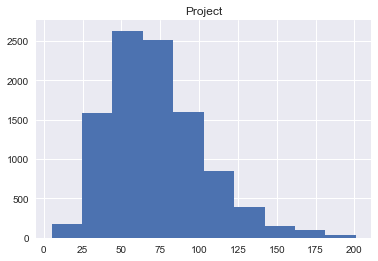

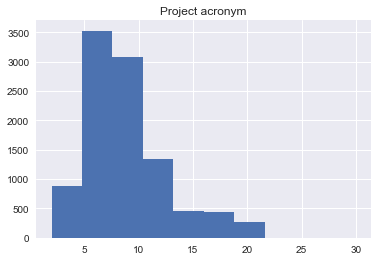

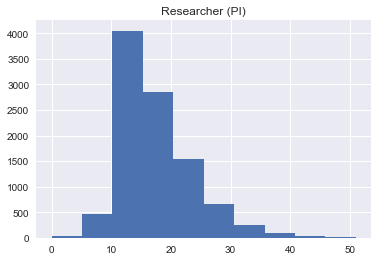

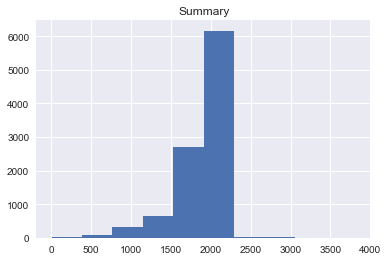

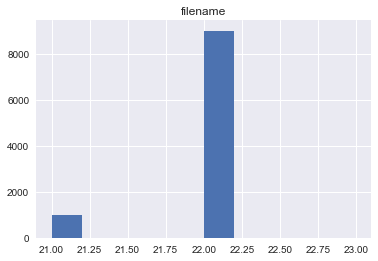

In [221]:
## Count Nan values
df.apply(lambda x: x.isna().sum())
## Plot length of the String
for col in df.columns:
    plt.figure()
    plt.hist(df[col].fillna('').apply(len))
    plt.title(col)


### Do simple descriptives to see if everything make sense

In [203]:
df['Host Institution (HI)'].value_counts().head(15)

CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE CNRS                     507
THE CHANCELLOR MASTERS AND SCHOLARS OF THE UNIVERSITY OF CAMBRIDGE    262
THE CHANCELLOR, MASTERS AND SCHOLARS OF THE UNIVERSITY OF OXFORD      260
MAX-PLANCK-GESELLSCHAFT ZUR FORDERUNG DER WISSENSCHAFTEN EV           240
UNIVERSITY COLLEGE LONDON                                             184
WEIZMANN INSTITUTE OF SCIENCE                                         183
EIDGENOESSISCHE TECHNISCHE HOCHSCHULE ZUERICH                         172
ECOLE POLYTECHNIQUE FEDERALE DE LAUSANNE                              170
THE HEBREW UNIVERSITY OF JERUSALEM                                    138
IMPERIAL COLLEGE OF SCIENCE TECHNOLOGY AND MEDICINE                   122
INSTITUT NATIONAL DE LA SANTE ET DE LA RECHERCHE MEDICALE             116
THE UNIVERSITY OF EDINBURGH                                           109
KOBENHAVNS UNIVERSITET                                                 96
LUDWIG-MAXIMILIANS-UNIVERSITAET MUENCH

In [204]:
df['Researcher (PI)'].value_counts().head()

Susana Marcos Celestino    4
Jacob KLEIN                4
Andreas HERRMANN           3
Didier Trono               3
Eduard Arzt                3
Name: Researcher (PI), dtype: int64

In [207]:
df['Project acronym'].value_counts().head()

INTERACT    8
IMAGINE     5
COSMOS      5
SMART       5
QUEST       4
Name: Project acronym, dtype: int64

## Reliability and Data quality (2)
### Visualize the Log

In [222]:
# Load the LOG
import pandas as pd
log_df = pd.read_csv('erc_log.csv',sep=';') # load the ;-separated log 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [242]:
dt = log_df.dt.values[0]

In [249]:
import datetime
# Convert the time column 't' to datetime 
#log_df['dt'] = log_df.t.apply(datetime.datetime.fromtimestamp)
log_df['dt'] = pd.to_datetime(log_df.t,unit='s')

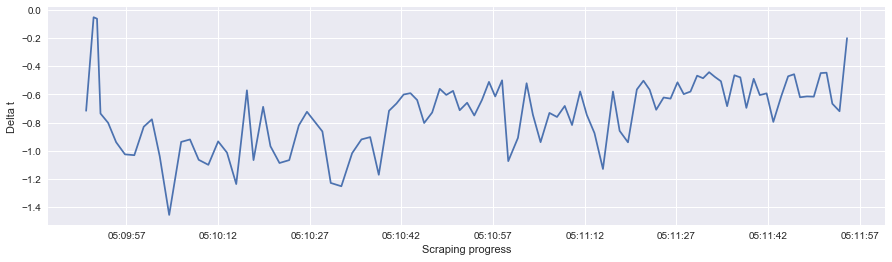

In [226]:
# Plot the time it took to make the call
plt.figure(figsize=(15,4))
plt.plot(log_df.dt,log_df.delta_t)
plt.ylabel('Delta t')
plt.xlabel('Scraping progress')
import datetime

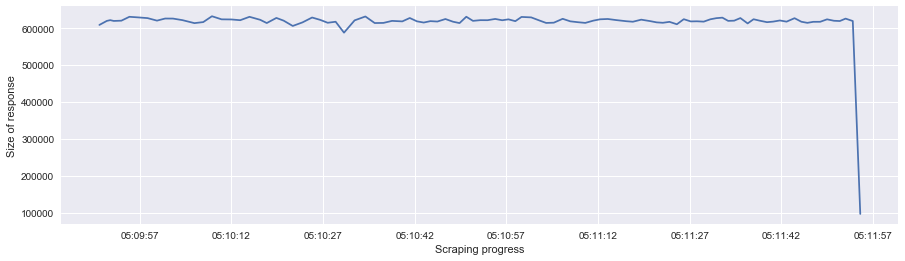

In [227]:
# Plot the response size over time.
plt.figure(figsize=(15,4))
plt.ylabel('Size of response')
plt.xlabel('Scraping progress')
plt.plot(log_df.dt,log_df.response_size)

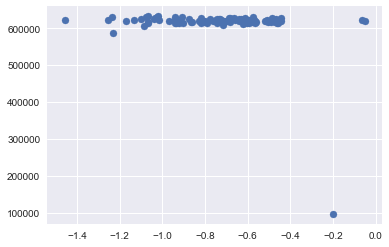

In [231]:
# Plot the delta_t against the response_size. These two should correlate pretty well.
plt.scatter(log_df.delta_t,log_df.response_size)

In [250]:
## Investigate errors
log_df.success.value_counts() ## Count errors
## Groupby time
# round the time for aggregation
log_df['dt_minute'] = log_df.dt.apply(lambda x: x-datetime.timedelta(seconds=x.second,microseconds=x.microsecond))
log_df['dt_hour'] = log_df.dt.apply(lambda x: x-datetime.timedelta(minutes=x.minute,seconds=x.second,microseconds=x.microsecond))
log_df.groupby('dt_hour').success.mean()


dt_hour
2019-08-16 05:00:00.000000000    True
2019-08-16 05:00:00.000000999    True
Name: success, dtype: bool

# Extracting patterns from Raw Text

of course you already now your basic string operations:

`string.split
string.strip
string.replace`

And sometimes this will be enough, but sometimes it is not.

# Regular Expressions
![](https://cdn-images-1.medium.com/max/800/0*j1f-EFL7TDtf6K0o.jpg)

Regex can be a little terrifying:

`pattern = '(?:(?:\r\n)?[ \t])*(?:(?:(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*))*@(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*))*|(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*)*\<(?:(?:\r\n)?[ \t])*(?:@(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*))*(?:,@(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*))*)*:(?:(?:\r\n)?[ \t])*)?(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*))*@(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*))*\>(?:(?:\r\n)?[ \t])*)|(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*)*:(?:(?:\r\n)?[ \t])*(?:(?:(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*))*@(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*))*|(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*)*\<(?:(?:\r\n)?[ \t])*(?:@(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*))*(?:,@(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*))*)*:(?:(?:\r\n)?[ \t])*)?(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*))*@(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*))*\>(?:(?:\r\n)?[ \t])*)(?:,\s*(?:(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*))*@(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*))*|(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*)*\<(?:(?:\r\n)?[ \t])*(?:@(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*))*(?:,@(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*))*)*:(?:(?:\r\n)?[ \t])*)?(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|"(?:[^\"\r\\]|\\.|(?:(?:\r\n)?[ \t]))*"(?:(?:\r\n)?[ \t])*))*@(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*)(?:\.(?:(?:\r\n)?[ \t])*(?:[^()<>@,;:\\".\[\] \000-\031]+(?:(?:(?:\r\n)?[ \t])+|\Z|(?=[\["()<>@,;:\\".\[\]]))|\[([^\[\]\r\\]|\\.)*\](?:(?:\r\n)?[ \t])*))*\>(?:(?:\r\n)?[ \t])*))*)?;\s*)'`


However creating regular expressions is also fun, fun as in Suduko, and it is extremely valuable when working with any kind of text: e.g. Automating otherwise tedious manual tasks when cleaning a data set, searching, extracting and substituting specific patterns.

Examples could be: 
- Extract currency and amount from raw text: $ 20, 10.000 dollars 10,000 £
- email addresses: here you want to design a pattern (as above), that captures only the uses of @ within an email.
- urls. Here you are trying to define all the different ways of writing urls (https, http, no http). 
- Dates. Again many variations: 17th of June 2017, 06/17/17 or 17. June 17
- addresses, 
- phone numbers: 8888888 or 88 88 88 88 or +45 88 88 88 88,
- emojiies in text. Capturing all the different ways of expressing smiley faces with one regular expression. 




** Regular Expression syntax **

Ressources:
Best way to learn is to practice, and with interactive examples. Two good ressources are here:
* Community and interactive playground [here](http://regexr.com/)
* Interactive tutorial [here](https://regexone.com/)
* or you can use your notebook.

Lookup all special characters [here](https://www.regular-expressions.info/refquick.html)

* \+ = 1 or more times  -- e.g. "a+" will match: "a", and "aaa"
* \* = 0 or more times  -- e.g. "ba*" will match: "b", and "ba", and "baaa"
* {3} = exactly three times --- e.g. "ba{3}" will match "baaa", but not "baa"
* ? = once or none
* \\ = escape character, used to find characters that has special meaning with regex: e.g. \+ \*
* [] = allows you to define a set of characters
* ^ = applied within a set, it becomes the inverse of the set defined. Applied outside a set it entails the beginning of a string. $ entails the end of a string.
* . = any characters except line break
* | = or statement. -- e.g. a|b means find characters a or b.
* \d = digits
* \D = any-non-digits.
* \s = whitespace-separator

Sequences
* (?:) = Defines a Non-capturing group. -- e.g. "(?:abc)+", will match "abc" and "abcabcabc", but not "aabbcc"
* (?=)	= Positive lookahead - only match a certain pattern if a certain pattern comes after it.
* (?!)	= Negative lookahead - only match a certain pattern if **not** a certain pattern comes after it.
* (?<=)	= Positive lookbehind - only match a certain pattern if a certain pattern precedes it.
* (?<!) = Negative lookbehind - only match a certain pattern if **not** a certain pattern precedes it.

## Regular expressions (2): define - inspect - refine
You are trying to balance getting (and learning/exploring) all the different variations of e.g. an emojii. while also making sure not to include ordinary use of :. 

This means iterating through many steps, some expressions being too broad others being to narrow, and others not matching all that you need.

I developed a small module for this that you can use. Just run the following piece of code to download, save and import the module.

```python 
# download module
url = 'https://raw.githubusercontent.com/snorreralund/explore_regex/master/explore_regex.py'
response = requests.get(url)
# write script to your folder to create a locate module
with open('explore_regex.py','w') as f:
    f.write(response.text)
# import local module
import explore_regex as e_re
```

## Lets do an example
first we get a dataset to play with. 
We download the following link using pandas and dump it to your local machine using the `pd.to_csv()` method.

In [1]:
import pandas as pd
import re
path2data = 'https://raw.githubusercontent.com/snorreralund/scraping_seminar/master/danish_review_sample.csv'
df = pd.read_csv(path2data)
df.to_csv('danish_review_sample.csv',index=False)

digit_re = re.compile('[0-9]+') # compiled regular expression for matching digits
df['hasNumber'] = df.reviewBody.apply(lambda x: len(digit_re.findall(x))>0) # check if it has a number


In [2]:
sample_string = '\n'.join(df[df.hasNumber].sample(2000).reviewBody)

In [3]:
import explore_regex as e_re
%matplotlib inline

In [4]:
# money example
#explore_money = ExploreRegex(sample_string)
explore_money = e_re.ExploreRegex(sample_string)
first = 'kr'
second = '[0-9]+kr'
third = '[0-9]+(?:[,.][0-9]+)?kr'
fourth = '[0-9]+(?:[,.][0-9]+)?\s{0,2}kr'
final = '[0-9]+(?:[,.][0-9]+)?\s{0,5}kr(?:oner)?'
patterns = [first,second,third,fourth,final]
for pattern in patterns:
    explore_money.explore_difference(pattern,patterns[0])
explore_money.explore_pattern(second)

------ Pattern: kr	 Matched 1071 patterns -----
Found 0 overlaps between the expressions:
        pattern1: kr 	 and
        pattern2: kr
        1071 included in pattern1 and not in the pattern2
        1071 was included in pattern2 and not in pattern1
------ Pattern: [0-9]+kr	 Matched 83 patterns -----
Found 166 overlaps between the expressions:
        pattern1: [0-9]+kr 	 and
        pattern2: kr
        0 included in pattern1 and not in the pattern2
        988 was included in pattern2 and not in pattern1
------ Pattern: [0-9]+(?:[,.][0-9]+)?kr	 Matched 83 patterns -----
Found 166 overlaps between the expressions:
        pattern1: [0-9]+(?:[,.][0-9]+)?kr 	 and
        pattern2: kr
        0 included in pattern1 and not in the pattern2
        988 was included in pattern2 and not in pattern1
------ Pattern: [0-9]+(?:[,.][0-9]+)?\s{0,2}kr	 Matched 343 patterns -----
Found 686 overlaps between the expressions:
        pattern1: [0-9]+(?:[,.][0-9]+)?\s{0,2}kr 	 and
        pattern2: 

------ Pattern: kr	 Matched 1071 patterns -----
------ Pattern: [0-9]+kr	 Matched 83 patterns -----
------ Pattern: [0-9]+(?:[,.][0-9]+)?kr	 Matched 83 patterns -----
------ Pattern: [0-9]+(?:[,.][0-9]+)?\s{0,2}kr	 Matched 343 patterns -----
------ Pattern: [0-9]+(?:[,.][0-9]+)?\s{0,5}kr(?:oner)?	 Matched 343 patterns -----


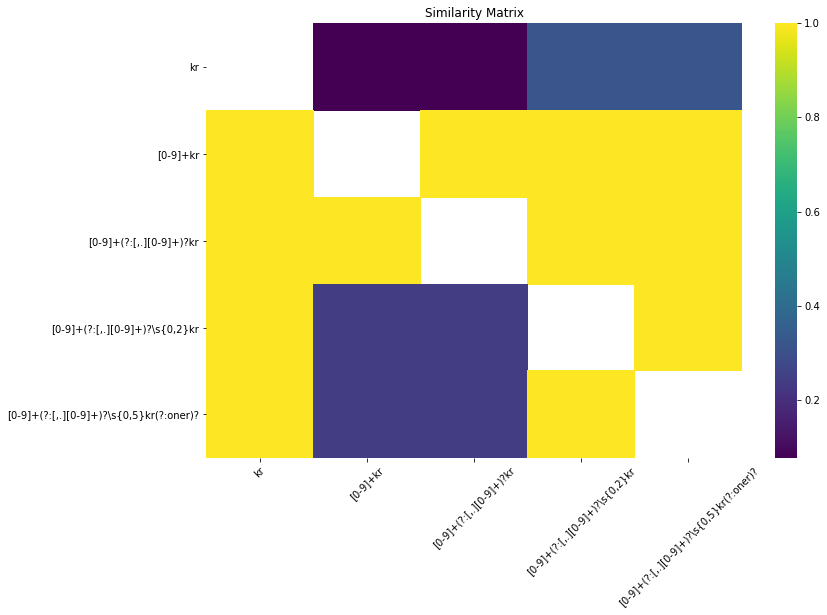

In [5]:
explore_money.report('soft')

------ Pattern: kr	 Matched 1071 patterns -----
------ Pattern: [0-9]+kr	 Matched 83 patterns -----
------ Pattern: [0-9]+(?:[,.][0-9]+)?kr	 Matched 83 patterns -----
------ Pattern: [0-9]+(?:[,.][0-9]+)?\s{0,2}kr	 Matched 343 patterns -----
------ Pattern: [0-9]+(?:[,.][0-9]+)?\s{0,5}kr(?:oner)?	 Matched 343 patterns -----


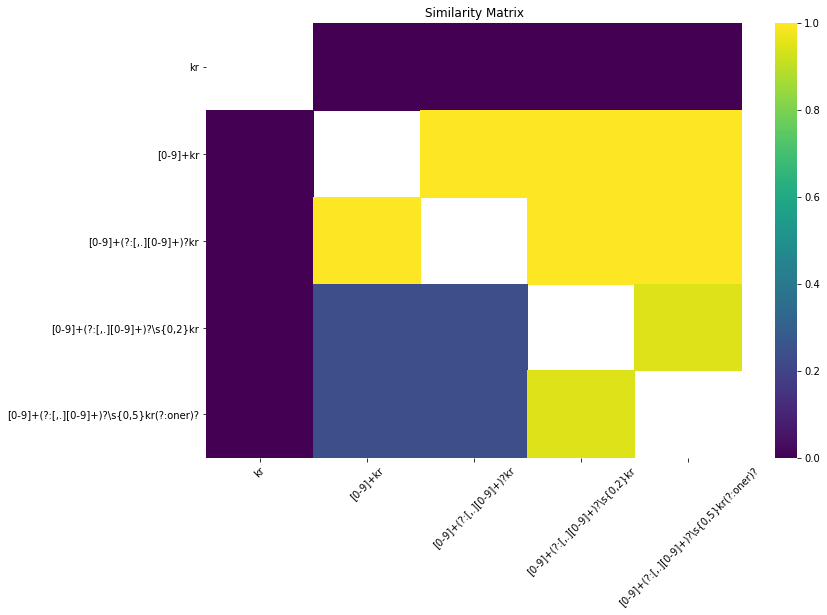

In [6]:
explore_money.report('hard')

In [7]:
print(explore_money.patterns[3],explore_money.patterns[4])
explore_money.explore_difference(explore_money.patterns[3],explore_money.patterns[4])

[0-9]+(?:[,.][0-9]+)?\s{0,2}kr [0-9]+(?:[,.][0-9]+)?\s{0,5}kr(?:oner)?
Found 686 overlaps between the expressions:
        pattern1: [0-9]+(?:[,.][0-9]+)?\s{0,2}kr 	 and
        pattern2: [0-9]+(?:[,.][0-9]+)?\s{0,5}kr(?:oner)?
        0 included in pattern1 and not in the pattern2
        0 was included in pattern2 and not in pattern1


([], [])